In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import multiprocessing
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')
cores = multiprocessing.cpu_count()
os.listdir()

['opencv-text-detection.zip',
 '.ipynb_checkpoints',
 'accepted_projects',
 'Andrew W. Trask - Grokking Deep Learning-Manning Publications (2019).pdf',
 'Collective_Dataset',
 'corpus',
 'corpus.zip',
 'doc2vec.ipynb',
 'doc2vec_with_kfold.html',
 'doc2vec_with_kfold.ipynb',
 'Final Slides and Books',
 'google-play-store-apps',
 'google-play-store-apps.zip',
 'helpline-of-all-sorts',
 'helpline-of-all-sorts.zip',
 'kmeans_clustering.html',
 'kmeans_clustering.ipynb',
 'labels.txt',
 'logistic_regression.ipynb',
 'MURA-v1.1',
 'MURA-v1.1.zip',
 'nltk',
 'opencv-text-detection',
 'Papers',
 'Papers.zip',
 'Papers_Association_Rule',
 'processed_dataset.csv',
 'Results',
 'reviews.txt',
 'sentiment_analysis_from_story_preprocessing.html',
 'sentiment_analysis_from_story_preprocessing.ipynb',
 'sentiment_dictionary.csv',
 'sklearn_test.ipynb',
 'Slides',
 'Story-categorization-using-NLP',
 'Tan.pdf',
 'Testing',
 'Udacity',
 'videodata.csv',
 'word2vec.model',
 'word2vector_test.ipynb']

In [2]:
df = pd.read_csv(os.getcwd() + "/Collective_Dataset/419_data - Sheet1.csv", usecols=[0,1])#header=None, , names=['story', 'category']

In [3]:
df.head(10)

,story,category
0,"Just like any other day, employees arrived in ...",0
1,My so-called ‘friends’ in middle school used t...,1
2,i have been called hurtful names and i have be...,1
3,at my old school kids would hit me and call me...,1
4,I had debilitating migraines for three years b...,0
5,"I love my work, but hate going each day becaus...",0
6,I have a chronic illness which was doing well ...,0
7,The other part is that sense of worthlessness....,0
8,I feel my whole body hurting. My mental health...,0
9,"As a librarian, I've been threatened with stal...",2


In [4]:
df['story']

0      Just like any other day, employees arrived in ...
1      My so-called ‘friends’ in middle school used t...
2      i have been called hurtful names and i have be...
3      at my old school kids would hit me and call me...
4      I had debilitating migraines for three years b...
                             ...                        
250    Yes, software jobs are stressful. They are pre...
251    I was doing what I thought was my dream job. I...
252    All of my work experience has been in the Los ...
253    I remember it very vividly: me, lying on my be...
254    My stress strikes when I find out that I am th...
Name: story, Length: 255, dtype: object

In [5]:
df['category']

0      0
1      1
2      1
3      1
4      0
      ..
250    0
251    0
252    0
253    0
254    0
Name: category, Length: 255, dtype: int64

In [6]:
df.shape

(255, 2)

In [7]:
df.index = range(255)

In [8]:
df.story.apply(lambda x: len(x.split(' '))).sum()

47669

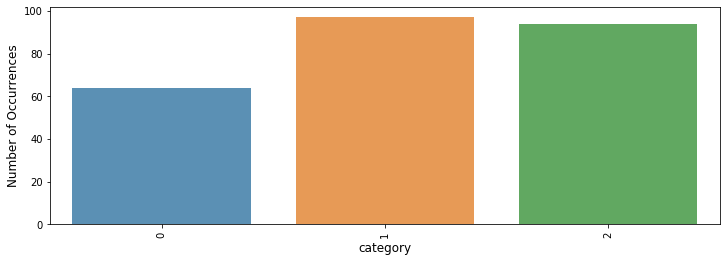

In [9]:
cnt_pro = df['category'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [10]:
work_stress_counter, bullying_counter, sexual_harassment_counter = 0, 0, 0
for c in df['category']:
    if c==0:
        work_stress_counter+=1
    elif c == 1:
        bullying_counter+=1
    else:
        sexual_harassment_counter+=1
print("Work Stress Total Data Count: ", work_stress_counter)
print("Bullying Total Data Count: ", bullying_counter)
print("Sexual Harassment Total Data Count: ", sexual_harassment_counter)

Work Stress Total Data Count:  64
Bullying Total Data Count:  97
Sexual Harassment Total Data Count:  94


In [11]:
print(df.story[2])
print(df.category[2])

i have been called hurtful names and i have been called black bitch and people are making fun of me for being black by my suppost to be friend t and she has posted rumors about me and i dont know what to do.
1


In [12]:
print(df.story[0])
print(df.category[0])

Just like any other day, employees arrived in the workplace sparingly, filling the cubicles and getting their coffees ready. Once more, the manager was already sitting at his desk, grumbling and shouting - You’re way too slow, again! How am I supposed to get my work done with you slowing me down every day? The other employees were staring at each other. They were embarrassed by his outburst but deep inside they knew he was right. Satisfied by the nods in the assembly, the manager calmed down. As usual, he quickly got absorbed by his screen and numerous emails. He was not the moody type, just a normal guy. His team liked him very much and his performance record was exemplary. He was often described as someone caring and trustworthy with a genuine interest in people. Yet once again, his fist hit the desk loudly as he started screaming. That’s it, I’m done! Slow and unreliable old crap! You made me lose five hours of my life, again. World will be better off without you and I’m going to le

In [13]:
print(df.story[10])
print(df.category[10])

I worked as an office manager, and the only woman, for an industrial insulation company. I had just come back from maternity leave and I was worried about my milk supply. I went into the bathroom to pump for about 15 minutes every two hours, and all of the men in the office would stand in the break area (right in front of the bathroom door) and make baby crying noises to make fun of me. Eventually it progressed to the point that they would make crying noises every time they passed my desk in hopes that I would leak through my shirt. They would also make comments about how much larger my breasts were since having a baby. I felt so harassed and unsafe that I would dread going to work every day, and I even had more than a few nervous breakdowns. My husband was furious and I had to convince him not to take any drastic action so that I could be sure to have a good reference if I needed to find another job. We had a long conversation and looked at our finances and decided the extra money was

In [14]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['story'] = df['story'].apply(cleanText)

In [15]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

### WITH TRAIN_TEST_SPLIT

In [16]:
train, test = train_test_split(df, test_size = .20, random_state = 2)

In [17]:
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)

In [18]:
train

,story,category
243,"when i joined the force 20 years ago, we were ...",0
25,"my bullying started, or when i first noticed i...",1
115,"and im 14 years old. all my life, i been bulli...",1
120,i am currently 17 years old and a junior in hi...,1
182,my eperiences with seual harassment at my reta...,2
...,...,...
22,"hi, i'm rahul. i was bullied all through schoo...",1
72,"when i was in 7th grade, i had a semester of m...",1
237,being a doctor is one of the hardest jobs main...,0
15,"i got made fun of for being fat in elementary,...",1


In [19]:
len(train)

204

In [20]:
test

,story,category
53,i’ve always been super flat-chested and i’m st...,1
13,i work in law enforcement. i started out as a ...,2
144,i felt my whole body hurting. my mental health...,0
94,"i'm 13 years old and live in nsw, australia wi...",1
159,"it was the late ‘60s, and apparently one of my...",2
71,i was around 12-13 years old and at this “meet...,1
85,my story might be short because i only remembe...,1
35,"when i got admitted in a well reputed college,...",1
3,at my old school kids would hit me and call me...,1
118,when i was around 10/11do to a little family i...,1


In [21]:
len(test)

51

In [22]:
train_tagged

243    ([when, joined, the, force, 20, years, ago, we...
25     ([my, bullying, started, or, when, first, noti...
115    ([and, im, 14, years, old, all, my, life, been...
120    ([am, currently, 17, years, old, and, junior, ...
182    ([my, eperiences, with, seual, harassment, at,...
                             ...                        
22     ([hi, 'm, rahul, was, bullied, all, through, s...
72     ([when, was, in, 7th, grade, had, semester, of...
237    ([being, doctor, is, one, of, the, hardest, jo...
15     ([got, made, fun, of, for, being, fat, in, ele...
168    ([let, me, tell, you, about, few, of, my, eper...
Length: 204, dtype: object

In [23]:
train_tagged.values[2]

TaggedDocument(words=['and', 'im', '14', 'years', 'old', 'all', 'my', 'life', 'been', 'bullied', 'non-stop', '1st', 'grade', 'to', '9th', 'grade', 'on', 'saturday', 'was', 'sleeping', 'in', 'got', 'call', 'from', 'blocked', 'number', 'calling', 'me', 'really', 'awful', 'names', 'telling', 'me', 'that', 'nobody', 'wants', 'me', 'here', 'and', 'for', 'me', 'to', 'kill', 'myself', 'just', 'let', 'it', 'go', 'fell', 'back', 'to', 'sleep..', 'got', 'another', 'call', 'from', 'restricted', 'tellin', 'me', 'the', 'same', 'thing', 'felt', 'devastated', 'everybody', 'in', 'that', 'school', 'thought', 'was', 'the', 'edited', 'felt', 'trashy', 'embarrassed', 'ran', 'down', 'the', 'hall', 'out', 'the', 'door', 'went', 'back', 'home', 'missed', 'weeks', 'of', 'school', 'the', 'bullying', 'was', 'bad', 'checked', 'my', 'facebook', 'everybody', 'was', 'talking', 'about', 'me', 'felt', 'worthless', 'lonely', 'tried', 'to', 'kill', 'myself', 'cut', 'took', '15', 'pills', 'nothing', 'happens', 'when', '

In [24]:
test_tagged.values[1]

TaggedDocument(words=['work', 'in', 'law', 'enforcement', 'started', 'out', 'as', 'correctional', 'officer', 'in', 'an', 'all-male', 'prison', 'when', 'was', 'walking', 'to', 'my', 'post', 'one', 'day', 'an', 'inmate', 'screamed', 'at', 'me', "'bitch", "'ll", 'beat', 'your', 'pussy', 'so', 'hard', 'it', "'ll", 'put', 'you', 'in', 'the', 'hospital', 'called', 'unit', 'code', 'because', 'to', 'me', 'that', 'is', 'harassment', 'violent', 'seual', 'harassment', 'but', 'because', 'worked', 'in', 'male', 'prison', 'was', 'supposed', 'to', 'let', 'it', 'go', 'in', 'one', 'ear', 'and', 'out', 'the', 'other'], tags=[2])

### PV-DBOW

In [25]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 204/204 [00:00<00:00, 839684.02it/s]


In [26]:
%%time
for epoch in range(5):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 204/204 [00:00<00:00, 1151598.94it/s]

CPU times: user 381 ms, sys: 16.3 ms, total: 397 ms
Wall time: 154 ms


In [27]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [28]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [29]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [30]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('\nTesting Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred),"\n")
print('Testing Classification Report: ')
print(classification_report(y_test, y_pred))

Testing accuracy 0.8235294117647058
Testing F1 score: 0.8209623371895177

Testing Confusion Matrix: 
[[ 8  1  0]
 [ 1 23  1]
 [ 3  3 11]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.67      0.89      0.76         9
           1       0.85      0.92      0.88        25
           2       0.92      0.65      0.76        17

    accuracy                           0.82        51
   macro avg       0.81      0.82      0.80        51
weighted avg       0.84      0.82      0.82        51



### PV-DM

In [31]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 204/204 [00:00<00:00, 1495870.66it/s]


In [32]:
%%time
for epoch in range(5):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 204/204 [00:00<00:00, 997247.10it/s]

CPU times: user 455 ms, sys: 23.6 ms, total: 478 ms
Wall time: 187 ms


In [33]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

In [34]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [35]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('\nTesting Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred),"\n")
print('Testing Classification Report: ')
print(classification_report(y_test, y_pred))

Testing accuracy 0.8823529411764706
Testing F1 score: 0.883290571130413

Testing Confusion Matrix: 
[[ 7  0  2]
 [ 0 23  2]
 [ 1  1 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.96      0.92      0.94        25
           2       0.79      0.88      0.83        17

    accuracy                           0.88        51
   macro avg       0.87      0.86      0.87        51
weighted avg       0.89      0.88      0.88        51



### Paired Model

In [36]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [37]:
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [38]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [39]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

In [40]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [41]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('\nTesting Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred),"\n")
print('Testing Classification Report: ')
print(classification_report(y_test, y_pred))

Testing accuracy 0.803921568627451
Testing F1 score: 0.808761927067704

Testing Confusion Matrix: 
[[ 6  0  3]
 [ 2 21  2]
 [ 2  1 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.60      0.67      0.63         9
           1       0.95      0.84      0.89        25
           2       0.74      0.82      0.78        17

    accuracy                           0.80        51
   macro avg       0.76      0.78      0.77        51
weighted avg       0.82      0.80      0.81        51



### WITH K-FOLD

In [42]:
X = df['story']
print("Length: ", len(X))
print("Type: ", type(X))
print("First Ten Values:\n", X[:10])
print(X[0])

Length:  255
Type:  <class 'pandas.core.series.Series'>
First Ten Values:
 0    just like any other day, employees arrived in ...
1    my so-called ‘friends’ in middle school used t...
2    i have been called hurtful names and i have be...
3    at my old school kids would hit me and call me...
4    i had debilitating migraines for three years b...
5    i love my work, but hate going each day becaus...
6    i have a chronic illness which was doing well ...
7    the other part is that sense of worthlessness....
8    i feel my whole body hurting. my mental health...
9    as a librarian, i've been threatened with stal...
Name: story, dtype: object
just like any other day, employees arrived in the workplace sparingly, filling the cubicles and getting their coffees ready. once more, the manager was already sitting at his desk, grumbling and shouting - you’re way too slow, again! how am i supposed to get my work done with you slowing me down every day? the other employees were staring at each

In [43]:
y = df['category']
print("Length: ", len(y))
print("Type: ", type(y))
print("First Ten Values: ", y[:10])

Length:  255
Type:  <class 'pandas.core.series.Series'>
First Ten Values:  0    0
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    0
9    2
Name: category, dtype: int64


In [44]:
ten_fold = KFold(n_splits=5, shuffle = True, random_state=42)
ten_fold

KFold(n_splits=5, random_state=42, shuffle=True)

In [45]:
print("Total Fold: ", ten_fold.get_n_splits(X))
fold_no = 1
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("X_train: ", X_train.shape, "X_test: ", X_test.shape)

Total Fold:  5
X_train:  (204,) X_test:  (51,)
X_train:  (204,) X_test:  (51,)
X_train:  (204,) X_test:  (51,)
X_train:  (204,) X_test:  (51,)
X_train:  (204,) X_test:  (51,)


In [46]:
total_fold = ten_fold.get_n_splits(X)
print(total_fold)

5


### K-FOLD PV-DBOW

In [47]:
print("Total Fold: ", total_fold)
fold_no = 1
for train_index, test_index in ten_fold.split(X):
    print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold: ", fold_no, "", len(X_train))
    print("No. of Testing Dataset in Fold: ", fold_no, "", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
    
    logreg = LogisticRegression(n_jobs=1, C=1e5)
    logreg.fit(X_trained, y_trained)
    y_pred = logreg.predict(X_tested)
    
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    
    print("\n\n")
    fold_no+=1

Total Fold:  5
Train Fold No.:  [  0   1   2   3   4   5   7   8  11  12  13  14  17  20  21  22  23  26
  27  28  29  31  32  34  35  36  37  38  39  40  41  42  43  44  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  69  70  71  72  73  74  76  77  78  80  81  82  83  84  85  87  88  89
  90  91  92  93  94  95  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 118 119 121 122 123 125 126 127 128 129 130
 131 132 133 134 135 138 139 140 141 142 143 144 145 146 147 149 150 151
 153 154 155 156 157 158 159 160 161 162 163 165 166 168 169 170 171 172
 173 174 175 178 179 182 183 186 187 188 189 191 192 193 194 196 197 199
 202 203 204 207 208 210 211 212 213 214 215 217 218 219 220 223 224 225
 226 227 228 230 231 232 233 235 236 237 239 240 241 242 244 245 246 247
 248 249 250 251 253 254]  Test Fold No.:  [  6   9  10  15  16  18  19  24  25  30  33  45  66  67  68  75  79  86
  96  97 117 120 124 136 137 148 152 164 167 176 

100%|██████████| 204/204 [00:00<00:00, 1252764.30it/s]


Fold No.:  1
Testing accuracy 0.9019607843137255
Testing F1 score: 0.9014005602240897

Testing Confusion Matrix: 
[[ 9  1  1]
 [ 0 16  1]
 [ 1  1 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.89      0.94      0.91        17
           2       0.91      0.91      0.91        23

    accuracy                           0.90        51
   macro avg       0.90      0.89      0.89        51
weighted avg       0.90      0.90      0.90        51




Train Fold No.:  [  0   1   2   3   4   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  23  24  25  26  27  30  32  33  34  36  37  39  40  41  43  44
  45  46  47  48  49  50  51  52  53  54  57  58  59  61  62  63  64  66
  67  68  70  71  72  74  75  76  77  78  79  80  81  83  86  87  88  89
  91  92  94  95  96  97  98  99 100 102 103 105 106 107 110 116 117 118
 119 120 121 122 123 124 128 129 130 131 133 134 

100%|██████████| 204/204 [00:00<00:00, 729444.17it/s]


Fold No.:  2
Testing accuracy 0.8431372549019608
Testing F1 score: 0.8443080732636227

Testing Confusion Matrix: 
[[10  1  1]
 [ 0 21  3]
 [ 2  1 12]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        12
           1       0.91      0.88      0.89        24
           2       0.75      0.80      0.77        15

    accuracy                           0.84        51
   macro avg       0.83      0.84      0.83        51
weighted avg       0.85      0.84      0.84        51




Train Fold No.:  [  1   3   5   6   7   8   9  10  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  28  29  30  31  33  34  35  37  38  39  40  42  43  44
  45  47  48  49  50  52  53  54  55  56  57  58  59  60  63  64  65  66
  67  68  69  71  72  73  74  75  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  96  97  99 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 120 121 123 124 

100%|██████████| 204/204 [00:00<00:00, 789333.96it/s]


Fold No.:  3
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8631211857018308

Testing Confusion Matrix: 
[[14  0  2]
 [ 1 16  1]
 [ 0  3 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.84      0.89      0.86        18
           2       0.82      0.82      0.82        17

    accuracy                           0.86        51
   macro avg       0.87      0.86      0.86        51
weighted avg       0.86      0.86      0.86        51




Train Fold No.:  [  0   1   2   4   5   6   9  10  11  12  14  15  16  18  19  20  21  22
  24  25  26  27  28  29  30  31  32  33  35  36  37  38  41  42  45  46
  48  50  51  52  54  55  56  57  58  60  61  62  63  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  82  84  85  86  87  88  90  92  93
  95  96  97  98  99 100 101 102 103 104 106 107 108 109 111 112 113 114
 115 116 117 118 119 120 121 122 124 125 126 127 

100%|██████████| 204/204 [00:00<00:00, 1358155.58it/s]


Fold No.:  4
Testing accuracy 0.9215686274509803
Testing F1 score: 0.9198978926382082

Testing Confusion Matrix: 
[[12  2  1]
 [ 1 15  0]
 [ 0  0 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.88      0.94      0.91        16
           2       0.95      1.00      0.98        20

    accuracy                           0.92        51
   macro avg       0.92      0.91      0.91        51
weighted avg       0.92      0.92      0.92        51




Train Fold No.:  [  0   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18  19
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38  39  40
  41  42  43  44  45  46  47  49  51  53  55  56  59  60  61  62  64  65
  66  67  68  69  70  72  73  75  76  77  78  79  80  81  82  83  84  85
  86  89  90  91  93  94  95  96  97  98 100 101 104 105 108 109 110 111
 112 113 114 115 117 118 119 120 122 123 124 125 

100%|██████████| 204/204 [00:00<00:00, 1034628.80it/s]


Fold No.:  5
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8573270006311309

Testing Confusion Matrix: 
[[ 6  2  2]
 [ 0 21  1]
 [ 0  2 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.84      0.95      0.89        22
           2       0.85      0.89      0.87        19

    accuracy                           0.86        51
   macro avg       0.90      0.82      0.84        51
weighted avg       0.88      0.86      0.86        51






### K-FOLD PV-DM 

In [48]:
fold_no = 1
print("Total Fold: ", total_fold)
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    logreg = LogisticRegression(n_jobs=1, C=1e5)
    logreg.fit(X_trained, y_trained)
    y_pred = logreg.predict(X_tested)
    
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    print("\n\n")
    fold_no+=1

Total Fold:  5
No. of Training Dataset in Fold  1 :  204
No. of Testing Dataset in Fold  1 :  51


100%|██████████| 204/204 [00:00<00:00, 695640.66it/s]


Fold No.:  1
Testing accuracy 0.9019607843137255
Testing F1 score: 0.901883306514095

Testing Confusion Matrix: 
[[ 9  0  2]
 [ 0 16  1]
 [ 0  2 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.89      0.94      0.91        17
           2       0.88      0.91      0.89        23

    accuracy                           0.90        51
   macro avg       0.92      0.89      0.90        51
weighted avg       0.91      0.90      0.90        51




No. of Training Dataset in Fold  2 :  204
No. of Testing Dataset in Fold  2 :  51


100%|██████████| 204/204 [00:00<00:00, 1085835.05it/s]


Fold No.:  2
Testing accuracy 0.9215686274509803
Testing F1 score: 0.9207545087000317

Testing Confusion Matrix: 
[[10  1  1]
 [ 0 24  0]
 [ 2  0 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        12
           1       0.96      1.00      0.98        24
           2       0.93      0.87      0.90        15

    accuracy                           0.92        51
   macro avg       0.91      0.90      0.90        51
weighted avg       0.92      0.92      0.92        51




No. of Training Dataset in Fold  3 :  204
No. of Testing Dataset in Fold  3 :  51


100%|██████████| 204/204 [00:00<00:00, 1269492.61it/s]


Fold No.:  3
Testing accuracy 0.8431372549019608
Testing F1 score: 0.844424256188962

Testing Confusion Matrix: 
[[12  1  3]
 [ 0 16  2]
 [ 0  2 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        16
           1       0.84      0.89      0.86        18
           2       0.75      0.88      0.81        17

    accuracy                           0.84        51
   macro avg       0.86      0.84      0.84        51
weighted avg       0.86      0.84      0.84        51




No. of Training Dataset in Fold  4 :  204
No. of Testing Dataset in Fold  4 :  51


100%|██████████| 204/204 [00:00<00:00, 1495870.66it/s]


Fold No.:  4
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8580065625209263

Testing Confusion Matrix: 
[[10  1  4]
 [ 1 15  0]
 [ 0  1 19]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.67      0.77        15
           1       0.88      0.94      0.91        16
           2       0.83      0.95      0.88        20

    accuracy                           0.86        51
   macro avg       0.87      0.85      0.85        51
weighted avg       0.87      0.86      0.86        51




No. of Training Dataset in Fold  5 :  204
No. of Testing Dataset in Fold  5 :  51


100%|██████████| 204/204 [00:00<00:00, 879381.31it/s]


Fold No.:  5
Testing accuracy 0.9411764705882353
Testing F1 score: 0.938138239513883

Testing Confusion Matrix: 
[[ 7  0  3]
 [ 0 22  0]
 [ 0  0 19]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      1.00      1.00        22
           2       0.86      1.00      0.93        19

    accuracy                           0.94        51
   macro avg       0.95      0.90      0.92        51
weighted avg       0.95      0.94      0.94        51






### PAIRED MODEL

In [49]:
fold_no = 1
print("Total Fold No.: {}\n\n" .format(total_fold))
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
    
    logreg_dbow = LogisticRegression(n_jobs=1, C=1e5)
    logreg_dbow.fit(X_trained, y_trained)
    y_pred = logreg_dbow.predict(X_tested)
    
    print("FOR PV_DBOW: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    logreg_dm = LogisticRegression(n_jobs=1, C=1e5)
    logreg_dm.fit(X_trained, y_trained)
    y_pred = logreg_dm.predict(X_tested)
    
    print("FOR PV_DM: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    logreg_paired = LogisticRegression(n_jobs=1, C=1e5)
    logreg_paired.fit(X_train, y_train)
    y_pred = logreg_paired.predict(X_test)
    
    print("FOR Paired Model: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 5


No. of Training Dataset in Fold  1 :  204
No. of Testing Dataset in Fold  1 :  51


100%|██████████| 204/204 [00:00<00:00, 696206.69it/s]

FOR PV_DBOW: 
Fold No.:  1
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8626453038217745

Testing Confusion Matrix: 
[[ 9  1  1]
 [ 0 16  1]
 [ 1  3 19]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.80      0.94      0.86        17
           2       0.90      0.83      0.86        23

    accuracy                           0.86        51
   macro avg       0.87      0.86      0.86        51
weighted avg       0.87      0.86      0.86        51







100%|██████████| 204/204 [00:00<00:00, 51162.28it/s]


FOR PV_DM: 
Fold No.:  1
Testing accuracy 0.8235294117647058
Testing F1 score: 0.8159041394335511

Testing Confusion Matrix: 
[[ 6  1  4]
 [ 0 16  1]
 [ 1  2 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.84      0.94      0.89        17
           2       0.80      0.87      0.83        23

    accuracy                           0.82        51
   macro avg       0.83      0.79      0.80        51
weighted avg       0.83      0.82      0.82        51




FOR Paired Model: 
Testing accuracy 0.8431372549019608
Testing F1 score: 0.841665194606371

Testing Confusion Matrix: 
[[ 8  1  2]
 [ 0 16  1]
 [ 1  3 19]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.80      0.94      0.86        17
           2       0.86      0.83      0.84        23

    accurac

100%|██████████| 204/204 [00:00<00:00, 1186737.89it/s]

FOR PV_DBOW: 
Fold No.:  2
Testing accuracy 0.803921568627451
Testing F1 score: 0.8080247814593166

Testing Confusion Matrix: 
[[10  1  1]
 [ 0 20  4]
 [ 4  0 11]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.95      0.83      0.89        24
           2       0.69      0.73      0.71        15

    accuracy                           0.80        51
   macro avg       0.78      0.80      0.79        51
weighted avg       0.82      0.80      0.81        51







100%|██████████| 204/204 [00:00<00:00, 683963.24it/s]


FOR PV_DM: 
Fold No.:  2
Testing accuracy 0.8431372549019608
Testing F1 score: 0.8455065359477125

Testing Confusion Matrix: 
[[10  1  1]
 [ 1 20  3]
 [ 2  0 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.95      0.83      0.89        24
           2       0.76      0.87      0.81        15

    accuracy                           0.84        51
   macro avg       0.83      0.84      0.83        51
weighted avg       0.85      0.84      0.85        51




FOR Paired Model: 
Testing accuracy 0.8823529411764706
Testing F1 score: 0.8845170175093449

Testing Confusion Matrix: 
[[11  0  1]
 [ 0 22  2]
 [ 3  0 12]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        12
           1       1.00      0.92      0.96        24
           2       0.80      0.80      0.80        15

    accura

100%|██████████| 204/204 [00:00<00:00, 827502.92it/s]

FOR PV_DBOW: 
Fold No.:  3
Testing accuracy 0.8431372549019608
Testing F1 score: 0.8436974789915965

Testing Confusion Matrix: 
[[14  0  2]
 [ 1 15  2]
 [ 1  2 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.88      0.83      0.86        18
           2       0.78      0.82      0.80        17

    accuracy                           0.84        51
   macro avg       0.85      0.84      0.84        51
weighted avg       0.85      0.84      0.84        51







100%|██████████| 204/204 [00:00<00:00, 1028411.08it/s]


FOR PV_DM: 
Fold No.:  3
Testing accuracy 0.803921568627451
Testing F1 score: 0.8047368051163117

Testing Confusion Matrix: 
[[13  1  2]
 [ 1 14  3]
 [ 1  2 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.81      0.84        16
           1       0.82      0.78      0.80        18
           2       0.74      0.82      0.78        17

    accuracy                           0.80        51
   macro avg       0.81      0.80      0.81        51
weighted avg       0.81      0.80      0.80        51




FOR Paired Model: 
Testing accuracy 0.803921568627451
Testing F1 score: 0.8041950869275348

Testing Confusion Matrix: 
[[13  1  2]
 [ 1 15  2]
 [ 1  3 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.81      0.84        16
           1       0.79      0.83      0.81        18
           2       0.76      0.76      0.76        17

    accuracy

100%|██████████| 204/204 [00:00<00:00, 744680.61it/s]

FOR PV_DBOW: 
Fold No.:  4
Testing accuracy 0.8823529411764706
Testing F1 score: 0.8796649973120562

Testing Confusion Matrix: 
[[11  1  3]
 [ 1 15  0]
 [ 0  1 19]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.88      0.94      0.91        16
           2       0.86      0.95      0.90        20

    accuracy                           0.88        51
   macro avg       0.89      0.87      0.88        51
weighted avg       0.89      0.88      0.88        51







100%|██████████| 204/204 [00:00<00:00, 1292504.56it/s]


FOR PV_DM: 
Fold No.:  4
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8615001556178027

Testing Confusion Matrix: 
[[11  2  2]
 [ 1 15  0]
 [ 0  2 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.79      0.94      0.86        16
           2       0.90      0.90      0.90        20

    accuracy                           0.86        51
   macro avg       0.87      0.86      0.86        51
weighted avg       0.87      0.86      0.86        51




FOR Paired Model: 
Testing accuracy 0.9019607843137255
Testing F1 score: 0.8985661448041748

Testing Confusion Matrix: 
[[11  1  3]
 [ 1 15  0]
 [ 0  0 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.94      0.94      0.94        16
           2       0.87      1.00      0.93        20

    accura

100%|██████████| 204/204 [00:00<00:00, 829106.60it/s]

FOR PV_DBOW: 
Fold No.:  5
Testing accuracy 0.8431372549019608
Testing F1 score: 0.8417211328976034

Testing Confusion Matrix: 
[[ 7  2  1]
 [ 0 19  3]
 [ 1  1 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.86      0.86      0.86        22
           2       0.81      0.89      0.85        19

    accuracy                           0.84        51
   macro avg       0.85      0.82      0.83        51
weighted avg       0.85      0.84      0.84        51







100%|██████████| 204/204 [00:00<00:00, 571186.93it/s]


FOR PV_DM: 
Fold No.:  5
Testing accuracy 0.9019607843137255
Testing F1 score: 0.8998213056312356

Testing Confusion Matrix: 
[[ 7  1  2]
 [ 0 20  2]
 [ 0  0 19]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.95      0.91      0.93        22
           2       0.83      1.00      0.90        19

    accuracy                           0.90        51
   macro avg       0.93      0.87      0.89        51
weighted avg       0.91      0.90      0.90        51




FOR Paired Model: 
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8620170366368161

Testing Confusion Matrix: 
[[ 7  1  2]
 [ 0 19  3]
 [ 0  1 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.90      0.86      0.88        22
           2       0.78      0.95      0.86        19

    accura

### Decision Tree Using Entropy

In [50]:
fold_no = 1
print("Total Fold No.: {}\n\n" .format(total_fold))
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW using DT with Entropy
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "entropy", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR PV_DBOW Using Decision Tree with Entropy: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "entropy", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR PV_DM Using Decision Tree with Entropy:  ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "entropy", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR Paired Model Using Decision Tree with Entropy: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 5


No. of Training Dataset in Fold  1 :  204
No. of Testing Dataset in Fold  1 :  51


100%|██████████| 204/204 [00:00<00:00, 1304326.24it/s]

FOR PV_DBOW Using Decision Tree with Entropy: 
Fold No.:  1
Testing accuracy 0.8823529411764706
Testing F1 score: 0.882103952692188

Testing Confusion Matrix: 
[[ 9  1  1]
 [ 0 16  1]
 [ 2  1 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.89      0.94      0.91        17
           2       0.91      0.87      0.89        23

    accuracy                           0.88        51
   macro avg       0.87      0.88      0.87        51
weighted avg       0.88      0.88      0.88        51







100%|██████████| 204/204 [00:00<00:00, 804171.07it/s]


FOR PV_DM Using Decision Tree with Entropy:  
Fold No.:  1
Testing accuracy 0.9215686274509803
Testing F1 score: 0.9204481792717086

Testing Confusion Matrix: 
[[ 9  0  2]
 [ 0 17  0]
 [ 1  1 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.94      1.00      0.97        17
           2       0.91      0.91      0.91        23

    accuracy                           0.92        51
   macro avg       0.92      0.91      0.91        51
weighted avg       0.92      0.92      0.92        51




FOR Paired Model Using Decision Tree with Entropy: 
Testing accuracy 0.9215686274509803
Testing F1 score: 0.9204481792717086

Testing Confusion Matrix: 
[[ 9  0  2]
 [ 0 17  0]
 [ 1  1 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.94      1.00      0.97        1

100%|██████████| 204/204 [00:00<00:00, 781404.58it/s]

FOR PV_DBOW Using Decision Tree with Entropy: 
Fold No.:  2
Testing accuracy 0.8431372549019608
Testing F1 score: 0.8436394678130271

Testing Confusion Matrix: 
[[ 9  2  1]
 [ 0 21  3]
 [ 2  0 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.91      0.88      0.89        24
           2       0.76      0.87      0.81        15

    accuracy                           0.84        51
   macro avg       0.83      0.83      0.83        51
weighted avg       0.85      0.84      0.84        51







100%|██████████| 204/204 [00:00<00:00, 853930.16it/s]


FOR PV_DM Using Decision Tree with Entropy:  
Fold No.:  2
Testing accuracy 0.8235294117647058
Testing F1 score: 0.8288755053213431

Testing Confusion Matrix: 
[[11  0  1]
 [ 2 22  0]
 [ 6  0  9]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.58      0.92      0.71        12
           1       1.00      0.92      0.96        24
           2       0.90      0.60      0.72        15

    accuracy                           0.82        51
   macro avg       0.83      0.81      0.80        51
weighted avg       0.87      0.82      0.83        51




FOR Paired Model Using Decision Tree with Entropy: 
Testing accuracy 0.8235294117647058
Testing F1 score: 0.8288755053213431

Testing Confusion Matrix: 
[[11  0  1]
 [ 2 22  0]
 [ 6  0  9]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.58      0.92      0.71        12
           1       1.00      0.92      0.96        2

100%|██████████| 204/204 [00:00<00:00, 754530.88it/s]

FOR PV_DBOW Using Decision Tree with Entropy: 
Fold No.:  3
Testing accuracy 0.8431372549019608
Testing F1 score: 0.8425951025571519

Testing Confusion Matrix: 
[[15  0  1]
 [ 3 15  0]
 [ 1  3 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        16
           1       0.83      0.83      0.83        18
           2       0.93      0.76      0.84        17

    accuracy                           0.84        51
   macro avg       0.85      0.85      0.84        51
weighted avg       0.85      0.84      0.84        51







100%|██████████| 204/204 [00:00<00:00, 673730.72it/s]


FOR PV_DM Using Decision Tree with Entropy:  
Fold No.:  3
Testing accuracy 0.803921568627451
Testing F1 score: 0.8067538126361656

Testing Confusion Matrix: 
[[13  0  3]
 [ 0 15  3]
 [ 1  3 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.81      0.87        16
           1       0.83      0.83      0.83        18
           2       0.68      0.76      0.72        17

    accuracy                           0.80        51
   macro avg       0.82      0.80      0.81        51
weighted avg       0.81      0.80      0.81        51




FOR Paired Model Using Decision Tree with Entropy: 
Testing accuracy 0.803921568627451
Testing F1 score: 0.8067538126361656

Testing Confusion Matrix: 
[[13  0  3]
 [ 0 15  3]
 [ 1  3 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.81      0.87        16
           1       0.83      0.83      0.83        18


100%|██████████| 204/204 [00:00<00:00, 799661.70it/s]

FOR PV_DBOW Using Decision Tree with Entropy: 
Fold No.:  4
Testing accuracy 0.8823529411764706
Testing F1 score: 0.8812549776099488

Testing Confusion Matrix: 
[[11  0  4]
 [ 1 15  0]
 [ 1  0 19]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.73      0.79        15
           1       1.00      0.94      0.97        16
           2       0.83      0.95      0.88        20

    accuracy                           0.88        51
   macro avg       0.89      0.87      0.88        51
weighted avg       0.89      0.88      0.88        51







100%|██████████| 204/204 [00:00<00:00, 797425.92it/s]


FOR PV_DM Using Decision Tree with Entropy:  
Fold No.:  4
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8533783965022398

Testing Confusion Matrix: 
[[ 9  3  3]
 [ 1 15  0]
 [ 0  0 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.60      0.72        15
           1       0.83      0.94      0.88        16
           2       0.87      1.00      0.93        20

    accuracy                           0.86        51
   macro avg       0.87      0.85      0.84        51
weighted avg       0.87      0.86      0.85        51




FOR Paired Model Using Decision Tree with Entropy: 
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8533783965022398

Testing Confusion Matrix: 
[[ 9  3  3]
 [ 1 15  0]
 [ 0  0 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.60      0.72        15
           1       0.83      0.94      0.88        1

100%|██████████| 204/204 [00:00<00:00, 615124.38it/s]

FOR PV_DBOW Using Decision Tree with Entropy: 
Fold No.:  5
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8613692443991826

Testing Confusion Matrix: 
[[ 7  2  1]
 [ 0 20  2]
 [ 0  2 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.83      0.91      0.87        22
           2       0.85      0.89      0.87        19

    accuracy                           0.86        51
   macro avg       0.89      0.83      0.85        51
weighted avg       0.87      0.86      0.86        51







100%|██████████| 204/204 [00:00<00:00, 936146.63it/s]


FOR PV_DM Using Decision Tree with Entropy:  
Fold No.:  5
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8619893764209741

Testing Confusion Matrix: 
[[ 7  1  2]
 [ 0 18  4]
 [ 0  0 19]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.95      0.82      0.88        22
           2       0.76      1.00      0.86        19

    accuracy                           0.86        51
   macro avg       0.90      0.84      0.86        51
weighted avg       0.89      0.86      0.86        51




FOR Paired Model Using Decision Tree with Entropy: 
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8619893764209741

Testing Confusion Matrix: 
[[ 7  1  2]
 [ 0 18  4]
 [ 0  0 19]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.95      0.82      0.88        2

### Decision Tree Using Gini

In [51]:
fold_no = 1
print("Total Fold No.: {}\n\n" .format(total_fold))
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW using DT with Entropy
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "gini", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR PV_DBOW Using Decision Tree with Gini: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "gini", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR PV_DM Using Decision Tree with Gini:  ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "gini", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR Paired Model Using Decision Tree with Gini: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 5


No. of Training Dataset in Fold  1 :  204
No. of Testing Dataset in Fold  1 :  51


100%|██████████| 204/204 [00:00<00:00, 1069547.52it/s]

FOR PV_DBOW Using Decision Tree with Gini: 
Fold No.:  1
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8615001556178027

Testing Confusion Matrix: 
[[ 8  2  1]
 [ 0 16  1]
 [ 2  1 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.84      0.94      0.89        17
           2       0.91      0.87      0.89        23

    accuracy                           0.86        51
   macro avg       0.85      0.85      0.85        51
weighted avg       0.86      0.86      0.86        51







100%|██████████| 204/204 [00:00<00:00, 786432.00it/s]


FOR PV_DM Using Decision Tree with Gini:  
Fold No.:  1
Testing accuracy 0.9019607843137255
Testing F1 score: 0.9021475256769375

Testing Confusion Matrix: 
[[ 9  1  1]
 [ 1 16  0]
 [ 1  1 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.89      0.94      0.91        17
           2       0.95      0.91      0.93        23

    accuracy                           0.90        51
   macro avg       0.89      0.89      0.89        51
weighted avg       0.90      0.90      0.90        51




FOR Paired Model Using Decision Tree with Gini: 
Testing accuracy 0.9019607843137255
Testing F1 score: 0.9021475256769375

Testing Confusion Matrix: 
[[ 9  1  1]
 [ 1 16  0]
 [ 1  1 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.89      0.94      0.91        17
    

100%|██████████| 204/204 [00:00<00:00, 747935.33it/s]

FOR PV_DBOW Using Decision Tree with Gini: 
Fold No.:  2
Testing accuracy 0.7843137254901961
Testing F1 score: 0.78758345048447

Testing Confusion Matrix: 
[[11  1  0]
 [ 1 18  5]
 [ 4  0 11]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.69      0.92      0.79        12
           1       0.95      0.75      0.84        24
           2       0.69      0.73      0.71        15

    accuracy                           0.78        51
   macro avg       0.77      0.80      0.78        51
weighted avg       0.81      0.78      0.79        51







100%|██████████| 204/204 [00:00<00:00, 1154707.17it/s]


FOR PV_DM Using Decision Tree with Gini:  
Fold No.:  2
Testing accuracy 0.8235294117647058
Testing F1 score: 0.8282572722800426

Testing Confusion Matrix: 
[[11  0  1]
 [ 0 20  4]
 [ 4  0 11]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.73      0.92      0.81        12
           1       1.00      0.83      0.91        24
           2       0.69      0.73      0.71        15

    accuracy                           0.82        51
   macro avg       0.81      0.83      0.81        51
weighted avg       0.85      0.82      0.83        51




FOR Paired Model Using Decision Tree with Gini: 
Testing accuracy 0.8235294117647058
Testing F1 score: 0.8282572722800426

Testing Confusion Matrix: 
[[11  0  1]
 [ 0 20  4]
 [ 4  0 11]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.73      0.92      0.81        12
           1       1.00      0.83      0.91        24
    

100%|██████████| 204/204 [00:00<00:00, 1356003.19it/s]

FOR PV_DBOW Using Decision Tree with Gini: 
Fold No.:  3
Testing accuracy 0.8627450980392157
Testing F1 score: 0.861284747314159

Testing Confusion Matrix: 
[[15  0  1]
 [ 1 16  1]
 [ 1  3 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        16
           1       0.84      0.89      0.86        18
           2       0.87      0.76      0.81        17

    accuracy                           0.86        51
   macro avg       0.86      0.86      0.86        51
weighted avg       0.86      0.86      0.86        51







100%|██████████| 204/204 [00:00<00:00, 648210.62it/s]


FOR PV_DM Using Decision Tree with Gini:  
Fold No.:  3
Testing accuracy 0.803921568627451
Testing F1 score: 0.8002285296402943

Testing Confusion Matrix: 
[[14  1  1]
 [ 1 16  1]
 [ 2  4 11]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        16
           1       0.76      0.89      0.82        18
           2       0.85      0.65      0.73        17

    accuracy                           0.80        51
   macro avg       0.81      0.80      0.80        51
weighted avg       0.81      0.80      0.80        51




FOR Paired Model Using Decision Tree with Gini: 
Testing accuracy 0.803921568627451
Testing F1 score: 0.8002285296402943

Testing Confusion Matrix: 
[[14  1  1]
 [ 1 16  1]
 [ 2  4 11]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        16
           1       0.76      0.89      0.82        18
      

100%|██████████| 204/204 [00:00<00:00, 1258291.20it/s]

FOR PV_DBOW Using Decision Tree with Gini: 
Fold No.:  4
Testing accuracy 0.9019607843137255
Testing F1 score: 0.8997629680741634

Testing Confusion Matrix: 
[[11  0  4]
 [ 1 15  0]
 [ 0  0 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       1.00      0.94      0.97        16
           2       0.83      1.00      0.91        20

    accuracy                           0.90        51
   macro avg       0.92      0.89      0.90        51
weighted avg       0.91      0.90      0.90        51







100%|██████████| 204/204 [00:00<00:00, 1165719.37it/s]


FOR PV_DM Using Decision Tree with Gini:  
Fold No.:  4
Testing accuracy 0.8235294117647058
Testing F1 score: 0.799083269671505

Testing Confusion Matrix: 
[[ 6  1  8]
 [ 0 16  0]
 [ 0  0 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        15
           1       0.94      1.00      0.97        16
           2       0.71      1.00      0.83        20

    accuracy                           0.82        51
   macro avg       0.89      0.80      0.79        51
weighted avg       0.87      0.82      0.80        51




FOR Paired Model Using Decision Tree with Gini: 
Testing accuracy 0.8235294117647058
Testing F1 score: 0.799083269671505

Testing Confusion Matrix: 
[[ 6  1  8]
 [ 0 16  0]
 [ 0  0 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        15
           1       0.94      1.00      0.97        16
      

100%|██████████| 204/204 [00:00<00:00, 1159401.11it/s]

FOR PV_DBOW Using Decision Tree with Gini: 
Fold No.:  5
Testing accuracy 0.8431372549019608
Testing F1 score: 0.8388320545609548

Testing Confusion Matrix: 
[[ 6  2  2]
 [ 0 20  2]
 [ 0  2 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.83      0.91      0.87        22
           2       0.81      0.89      0.85        19

    accuracy                           0.84        51
   macro avg       0.88      0.80      0.82        51
weighted avg       0.86      0.84      0.84        51







100%|██████████| 204/204 [00:00<00:00, 913167.57it/s]


FOR PV_DM Using Decision Tree with Gini:  
Fold No.:  5
Testing accuracy 0.8431372549019608
Testing F1 score: 0.8413429556675046

Testing Confusion Matrix: 
[[ 7  1  2]
 [ 2 18  2]
 [ 0  1 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.90      0.82      0.86        22
           2       0.82      0.95      0.88        19

    accuracy                           0.84        51
   macro avg       0.83      0.82      0.82        51
weighted avg       0.85      0.84      0.84        51




FOR Paired Model Using Decision Tree with Gini: 
Testing accuracy 0.8431372549019608
Testing F1 score: 0.8413429556675046

Testing Confusion Matrix: 
[[ 7  1  2]
 [ 2 18  2]
 [ 0  1 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.90      0.82      0.86        22
    

### K Nearest Neighbour with Minkowski Distance

In [52]:
fold_no = 1
print("Total Fold No.: {}\n\n" .format(total_fold))
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW using DT with Entropy
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
        
    knn_dbow = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski')
    knn_dbow.fit(X_trained, y_trained)
    y_pred = knn_dbow.predict(X_tested)
    
    print("FOR PV_DBOW Using KNN with Minkowski Distance: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    knn_dm = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski')
    knn_dm.fit(X_trained, y_trained)
    y_pred = knn_dm.predict(X_tested)
    
    print("FOR PV_DM Using KNN with Minkowski Distance: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    knn_mixed = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski')
    knn_mixed.fit(X_trained, y_trained)
    y_pred = knn_mixed.predict(X_tested)
    
    print("FOR PAIRED Model Using KNN with Minkowski Distance: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 5


No. of Training Dataset in Fold  1 :  204
No. of Testing Dataset in Fold  1 :  51


100%|██████████| 204/204 [00:00<00:00, 571186.93it/s]

FOR PV_DBOW Using KNN with Minkowski Distance: 
Fold No.:  1
Testing accuracy 0.9019607843137255
Testing F1 score: 0.9014005602240897

Testing Confusion Matrix: 
[[ 9  1  1]
 [ 0 16  1]
 [ 1  1 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.89      0.94      0.91        17
           2       0.91      0.91      0.91        23

    accuracy                           0.90        51
   macro avg       0.90      0.89      0.89        51
weighted avg       0.90      0.90      0.90        51







100%|██████████| 204/204 [00:00<00:00, 1183455.07it/s]


FOR PV_DM Using KNN with Minkowski Distance: 
Fold No.:  1
Testing accuracy 0.9019607843137255
Testing F1 score: 0.9012675777381659

Testing Confusion Matrix: 
[[ 9  1  1]
 [ 0 17  0]
 [ 2  1 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.89      1.00      0.94        17
           2       0.95      0.87      0.91        23

    accuracy                           0.90        51
   macro avg       0.89      0.90      0.89        51
weighted avg       0.90      0.90      0.90        51




FOR PAIRED Model Using KNN with Minkowski Distance: 
Testing accuracy 0.9019607843137255
Testing F1 score: 0.9012675777381659

Testing Confusion Matrix: 
[[ 9  1  1]
 [ 0 17  0]
 [ 2  1 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.89      1.00      0.94        

100%|██████████| 204/204 [00:00<00:00, 650675.30it/s]

FOR PV_DBOW Using KNN with Minkowski Distance: 
Fold No.:  2
Testing accuracy 0.8823529411764706
Testing F1 score: 0.8852450980392156

Testing Confusion Matrix: 
[[11  0  1]
 [ 0 21  3]
 [ 2  0 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       1.00      0.88      0.93        24
           2       0.76      0.87      0.81        15

    accuracy                           0.88        51
   macro avg       0.87      0.89      0.88        51
weighted avg       0.89      0.88      0.89        51







100%|██████████| 204/204 [00:00<00:00, 804927.58it/s]


FOR PV_DM Using KNN with Minkowski Distance: 
Fold No.:  2
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8649538713843232

Testing Confusion Matrix: 
[[10  1  1]
 [ 1 22  1]
 [ 3  0 12]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.96      0.92      0.94        24
           2       0.86      0.80      0.83        15

    accuracy                           0.86        51
   macro avg       0.84      0.85      0.84        51
weighted avg       0.87      0.86      0.86        51




FOR PAIRED Model Using KNN with Minkowski Distance: 
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8649538713843232

Testing Confusion Matrix: 
[[10  1  1]
 [ 1 22  1]
 [ 3  0 12]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.96      0.92      0.94        

100%|██████████| 204/204 [00:00<00:00, 833955.18it/s]

FOR PV_DBOW Using KNN with Minkowski Distance: 
Fold No.:  3
Testing accuracy 0.8431372549019608
Testing F1 score: 0.8425567595459237

Testing Confusion Matrix: 
[[14  1  1]
 [ 1 16  1]
 [ 1  3 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.80      0.89      0.84        18
           2       0.87      0.76      0.81        17

    accuracy                           0.84        51
   macro avg       0.85      0.84      0.84        51
weighted avg       0.85      0.84      0.84        51







100%|██████████| 204/204 [00:00<00:00, 820362.43it/s]


FOR PV_DM Using KNN with Minkowski Distance: 
Fold No.:  3
Testing accuracy 0.8235294117647058
Testing F1 score: 0.8221670802315963

Testing Confusion Matrix: 
[[14  1  1]
 [ 1 16  1]
 [ 1  4 12]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.76      0.89      0.82        18
           2       0.86      0.71      0.77        17

    accuracy                           0.82        51
   macro avg       0.83      0.82      0.82        51
weighted avg       0.83      0.82      0.82        51




FOR PAIRED Model Using KNN with Minkowski Distance: 
Testing accuracy 0.8235294117647058
Testing F1 score: 0.8221670802315963

Testing Confusion Matrix: 
[[14  1  1]
 [ 1 16  1]
 [ 1  4 12]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.76      0.89      0.82        

100%|██████████| 204/204 [00:00<00:00, 651170.48it/s]

FOR PV_DBOW Using KNN with Minkowski Distance: 
Fold No.:  4
Testing accuracy 0.9803921568627451
Testing F1 score: 0.9803511791341407

Testing Confusion Matrix: 
[[14  1  0]
 [ 0 16  0]
 [ 0  0 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.94      1.00      0.97        16
           2       1.00      1.00      1.00        20

    accuracy                           0.98        51
   macro avg       0.98      0.98      0.98        51
weighted avg       0.98      0.98      0.98        51







100%|██████████| 204/204 [00:00<00:00, 824314.08it/s]


FOR PV_DM Using KNN with Minkowski Distance: 
Fold No.:  4
Testing accuracy 0.9019607843137255
Testing F1 score: 0.8967532812583027

Testing Confusion Matrix: 
[[10  4  1]
 [ 0 16  0]
 [ 0  0 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        15
           1       0.80      1.00      0.89        16
           2       0.95      1.00      0.98        20

    accuracy                           0.90        51
   macro avg       0.92      0.89      0.89        51
weighted avg       0.92      0.90      0.90        51




FOR PAIRED Model Using KNN with Minkowski Distance: 
Testing accuracy 0.9019607843137255
Testing F1 score: 0.8967532812583027

Testing Confusion Matrix: 
[[10  4  1]
 [ 0 16  0]
 [ 0  0 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        15
           1       0.80      1.00      0.89        

100%|██████████| 204/204 [00:00<00:00, 1017405.49it/s]

FOR PV_DBOW Using KNN with Minkowski Distance: 
Fold No.:  5
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8615852877098553

Testing Confusion Matrix: 
[[ 7  1  2]
 [ 0 20  2]
 [ 0  2 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.87      0.91      0.89        22
           2       0.81      0.89      0.85        19

    accuracy                           0.86        51
   macro avg       0.89      0.83      0.85        51
weighted avg       0.87      0.86      0.86        51







100%|██████████| 204/204 [00:00<00:00, 802662.30it/s]


FOR PV_DM Using KNN with Minkowski Distance: 
Fold No.:  5
Testing accuracy 0.9411764705882353
Testing F1 score: 0.9399698340874811

Testing Confusion Matrix: 
[[ 8  0  2]
 [ 0 22  0]
 [ 0  1 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.96      1.00      0.98        22
           2       0.90      0.95      0.92        19

    accuracy                           0.94        51
   macro avg       0.95      0.92      0.93        51
weighted avg       0.94      0.94      0.94        51




FOR PAIRED Model Using KNN with Minkowski Distance: 
Testing accuracy 0.9411764705882353
Testing F1 score: 0.9399698340874811

Testing Confusion Matrix: 
[[ 8  0  2]
 [ 0 22  0]
 [ 0  1 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.96      1.00      0.98        

### K Nearest Neighbour with Euclidean Distance

In [53]:
fold_no = 1
print("Total Fold No.: {}\n\n" .format(total_fold))
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW using DT with Entropy
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
        
    knn_dbow = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')
    knn_dbow.fit(X_trained, y_trained)
    y_pred = knn_dbow.predict(X_tested)
    
    print("FOR PV_DBOW Using KNN with Euclidean Distance: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    knn_dm = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')
    knn_dm.fit(X_trained, y_trained)
    y_pred = knn_dm.predict(X_tested)
    
    print("FOR PV_DM Using KNN with Euclidean Distance: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    knn_mixed = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')
    knn_mixed.fit(X_trained, y_trained)
    y_pred = knn_mixed.predict(X_tested)
    
    print("FOR PAIRED Model Using KNN with Euclidean Distance: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 5


No. of Training Dataset in Fold  1 :  204
No. of Testing Dataset in Fold  1 :  51


100%|██████████| 204/204 [00:00<00:00, 818792.36it/s]

FOR PV_DBOW Using KNN with Euclidean Distance: 
Fold No.:  1
Testing accuracy 0.8823529411764706
Testing F1 score: 0.8820417055711174

Testing Confusion Matrix: 
[[ 9  1  1]
 [ 0 16  1]
 [ 1  2 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.84      0.94      0.89        17
           2       0.91      0.87      0.89        23

    accuracy                           0.88        51
   macro avg       0.88      0.88      0.88        51
weighted avg       0.88      0.88      0.88        51







100%|██████████| 204/204 [00:00<00:00, 1304326.24it/s]


FOR PV_DM Using KNN with Euclidean Distance: 
Fold No.:  1
Testing accuracy 0.9411764705882353
Testing F1 score: 0.9400560224089636

Testing Confusion Matrix: 
[[ 9  1  1]
 [ 0 17  0]
 [ 1  0 22]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.94      1.00      0.97        17
           2       0.96      0.96      0.96        23

    accuracy                           0.94        51
   macro avg       0.93      0.92      0.93        51
weighted avg       0.94      0.94      0.94        51




FOR PAIRED Model Using KNN with Euclidean Distance: 
Testing accuracy 0.9411764705882353
Testing F1 score: 0.9400560224089636

Testing Confusion Matrix: 
[[ 9  1  1]
 [ 0 17  0]
 [ 1  0 22]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.94      1.00      0.97        

100%|██████████| 204/204 [00:00<00:00, 787155.49it/s]

FOR PV_DBOW Using KNN with Euclidean Distance: 
Fold No.:  2
Testing accuracy 0.8823529411764706
Testing F1 score: 0.8852450980392156

Testing Confusion Matrix: 
[[11  0  1]
 [ 0 21  3]
 [ 2  0 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       1.00      0.88      0.93        24
           2       0.76      0.87      0.81        15

    accuracy                           0.88        51
   macro avg       0.87      0.89      0.88        51
weighted avg       0.89      0.88      0.89        51







100%|██████████| 204/204 [00:00<00:00, 753202.48it/s]


FOR PV_DM Using KNN with Euclidean Distance: 
Fold No.:  2
Testing accuracy 0.8235294117647058
Testing F1 score: 0.8293911970382558

Testing Confusion Matrix: 
[[10  0  2]
 [ 1 20  3]
 [ 3  0 12]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       1.00      0.83      0.91        24
           2       0.71      0.80      0.75        15

    accuracy                           0.82        51
   macro avg       0.81      0.82      0.81        51
weighted avg       0.85      0.82      0.83        51




FOR PAIRED Model Using KNN with Euclidean Distance: 
Testing accuracy 0.8235294117647058
Testing F1 score: 0.8293911970382558

Testing Confusion Matrix: 
[[10  0  2]
 [ 1 20  3]
 [ 3  0 12]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       1.00      0.83      0.91        

100%|██████████| 204/204 [00:00<00:00, 645277.54it/s]

FOR PV_DBOW Using KNN with Euclidean Distance: 
Fold No.:  3
Testing accuracy 0.8823529411764706
Testing F1 score: 0.8807404540763675

Testing Confusion Matrix: 
[[15  0  1]
 [ 0 17  1]
 [ 1  3 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.85      0.94      0.89        18
           2       0.87      0.76      0.81        17

    accuracy                           0.88        51
   macro avg       0.88      0.88      0.88        51
weighted avg       0.88      0.88      0.88        51







100%|██████████| 204/204 [00:00<00:00, 182283.34it/s]


FOR PV_DM Using KNN with Euclidean Distance: 
Fold No.:  3
Testing accuracy 0.7843137254901961
Testing F1 score: 0.7816571790006325

Testing Confusion Matrix: 
[[14  1  1]
 [ 1 15  2]
 [ 4  2 11]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.74      0.88      0.80        16
           1       0.83      0.83      0.83        18
           2       0.79      0.65      0.71        17

    accuracy                           0.78        51
   macro avg       0.79      0.79      0.78        51
weighted avg       0.79      0.78      0.78        51




FOR PAIRED Model Using KNN with Euclidean Distance: 
Testing accuracy 0.7843137254901961
Testing F1 score: 0.7816571790006325

Testing Confusion Matrix: 
[[14  1  1]
 [ 1 15  2]
 [ 4  2 11]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.74      0.88      0.80        16
           1       0.83      0.83      0.83        

100%|██████████| 204/204 [00:00<00:00, 672671.40it/s]

FOR PV_DBOW Using KNN with Euclidean Distance: 
Fold No.:  4
Testing accuracy 0.9411764705882353
Testing F1 score: 0.9418163535810595

Testing Confusion Matrix: 
[[14  1  0]
 [ 1 15  0]
 [ 0  1 19]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.88      0.94      0.91        16
           2       1.00      0.95      0.97        20

    accuracy                           0.94        51
   macro avg       0.94      0.94      0.94        51
weighted avg       0.94      0.94      0.94        51







100%|██████████| 204/204 [00:00<00:00, 515755.28it/s]


FOR PV_DM Using KNN with Euclidean Distance: 
Fold No.:  4
Testing accuracy 0.9215686274509803
Testing F1 score: 0.9197012138188607

Testing Confusion Matrix: 
[[12  1  2]
 [ 1 15  0]
 [ 0  0 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.94      0.94      0.94        16
           2       0.91      1.00      0.95        20

    accuracy                           0.92        51
   macro avg       0.92      0.91      0.92        51
weighted avg       0.92      0.92      0.92        51




FOR PAIRED Model Using KNN with Euclidean Distance: 
Testing accuracy 0.9215686274509803
Testing F1 score: 0.9197012138188607

Testing Confusion Matrix: 
[[12  1  2]
 [ 1 15  0]
 [ 0  0 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.94      0.94      0.94        

100%|██████████| 204/204 [00:00<00:00, 650180.86it/s]

FOR PV_DBOW Using KNN with Euclidean Distance: 
Fold No.:  5
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8600928294022923

Testing Confusion Matrix: 
[[ 7  1  2]
 [ 0 21  1]
 [ 1  2 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.88      0.95      0.91        22
           2       0.84      0.84      0.84        19

    accuracy                           0.86        51
   macro avg       0.86      0.83      0.84        51
weighted avg       0.86      0.86      0.86        51







100%|██████████| 204/204 [00:00<00:00, 920040.88it/s]


FOR PV_DM Using KNN with Euclidean Distance: 
Fold No.:  5
Testing accuracy 0.8627450980392157
Testing F1 score: 0.862286435041853

Testing Confusion Matrix: 
[[ 8  1  1]
 [ 0 20  2]
 [ 1  2 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.87      0.91      0.89        22
           2       0.84      0.84      0.84        19

    accuracy                           0.86        51
   macro avg       0.87      0.85      0.86        51
weighted avg       0.86      0.86      0.86        51




FOR PAIRED Model Using KNN with Euclidean Distance: 
Testing accuracy 0.8627450980392157
Testing F1 score: 0.862286435041853

Testing Confusion Matrix: 
[[ 8  1  1]
 [ 0 20  2]
 [ 1  2 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.87      0.91      0.89        22

### K-Fold With Gaussian Naive Bayes

In [54]:
fold_no = 1
print("Total Fold No.: {}\n\n" .format(total_fold))
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW using DT with Entropy
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
        
    nb_gaussian_pv_dbow = GaussianNB()
    nb_gaussian_pv_dbow.fit(X_trained, y_trained)
    y_pred = nb_gaussian_pv_dbow.predict(X_tested)
    
    print("FOR PV_DBOW Using Gaussian Naive Bayes: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    nb_gaussian_pv_dm = GaussianNB()
    nb_gaussian_pv_dm.fit(X_trained, y_trained)
    y_pred_pv_dm = nb_gaussian_pv_dm.predict(X_tested)
    
    print("FOR PV_DM Using Gaussian Naive Bayes: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    nb_gaussian_mixed = GaussianNB()
    nb_gaussian_mixed.fit(X_trained, y_trained)
    y_pred = nb_gaussian_mixed.predict(X_tested)
    
    print("FOR PAIRED Model Using Gaussian Naive Bayes: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 5


No. of Training Dataset in Fold  1 :  204
No. of Testing Dataset in Fold  1 :  51


100%|██████████| 204/204 [00:00<00:00, 464768.07it/s]

FOR PV_DBOW Using Gaussian Naive Bayes: 
Fold No.:  1
Testing accuracy 0.9019607843137255
Testing F1 score: 0.9023569023569024

Testing Confusion Matrix: 
[[10  1  0]
 [ 0 16  1]
 [ 1  2 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.84      0.94      0.89        17
           2       0.95      0.87      0.91        23

    accuracy                           0.90        51
   macro avg       0.90      0.91      0.90        51
weighted avg       0.91      0.90      0.90        51







100%|██████████| 204/204 [00:00<00:00, 600869.39it/s]


FOR PV_DM Using Gaussian Naive Bayes: 
Fold No.:  1
Testing accuracy 0.9019607843137255
Testing F1 score: 0.9023569023569024

Testing Confusion Matrix: 
[[10  1  0]
 [ 0 16  1]
 [ 1  2 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.84      0.94      0.89        17
           2       0.95      0.87      0.91        23

    accuracy                           0.90        51
   macro avg       0.90      0.91      0.90        51
weighted avg       0.91      0.90      0.90        51




FOR PAIRED Model Using Gaussian Naive Bayes: 
Testing accuracy 0.8823529411764706
Testing F1 score: 0.8807768083309879

Testing Confusion Matrix: 
[[ 8  2  1]
 [ 0 17  0]
 [ 1  2 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.81      1.00      0.89        17
           

100%|██████████| 204/204 [00:00<00:00, 1457645.68it/s]

FOR PV_DBOW Using Gaussian Naive Bayes: 
Fold No.:  2
Testing accuracy 0.8823529411764706
Testing F1 score: 0.8852450980392156

Testing Confusion Matrix: 
[[11  0  1]
 [ 0 21  3]
 [ 2  0 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       1.00      0.88      0.93        24
           2       0.76      0.87      0.81        15

    accuracy                           0.88        51
   macro avg       0.87      0.89      0.88        51
weighted avg       0.89      0.88      0.89        51







100%|██████████| 204/204 [00:00<00:00, 1488066.11it/s]


FOR PV_DM Using Gaussian Naive Bayes: 
Fold No.:  2
Testing accuracy 0.8823529411764706
Testing F1 score: 0.8852450980392156

Testing Confusion Matrix: 
[[11  0  1]
 [ 0 21  3]
 [ 2  0 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       1.00      0.88      0.93        24
           2       0.76      0.87      0.81        15

    accuracy                           0.88        51
   macro avg       0.87      0.89      0.88        51
weighted avg       0.89      0.88      0.89        51




FOR PAIRED Model Using Gaussian Naive Bayes: 
Testing accuracy 0.8823529411764706
Testing F1 score: 0.8845170175093449

Testing Confusion Matrix: 
[[11  0  1]
 [ 0 22  2]
 [ 3  0 12]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        12
           1       1.00      0.92      0.96        24
           

100%|██████████| 204/204 [00:00<00:00, 1173714.70it/s]

FOR PV_DBOW Using Gaussian Naive Bayes: 
Fold No.:  3
Testing accuracy 0.8627450980392157
Testing F1 score: 0.863095238095238

Testing Confusion Matrix: 
[[15  0  1]
 [ 3 15  0]
 [ 1  2 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        16
           1       0.88      0.83      0.86        18
           2       0.93      0.82      0.87        17

    accuracy                           0.86        51
   macro avg       0.87      0.86      0.86        51
weighted avg       0.87      0.86      0.86        51







100%|██████████| 204/204 [00:00<00:00, 889436.61it/s]


FOR PV_DM Using Gaussian Naive Bayes: 
Fold No.:  3
Testing accuracy 0.8627450980392157
Testing F1 score: 0.863095238095238

Testing Confusion Matrix: 
[[15  0  1]
 [ 3 15  0]
 [ 1  2 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        16
           1       0.88      0.83      0.86        18
           2       0.93      0.82      0.87        17

    accuracy                           0.86        51
   macro avg       0.87      0.86      0.86        51
weighted avg       0.87      0.86      0.86        51




FOR PAIRED Model Using Gaussian Naive Bayes: 
Testing accuracy 0.8235294117647058
Testing F1 score: 0.8235433924015239

Testing Confusion Matrix: 
[[14  1  1]
 [ 3 14  1]
 [ 1  2 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        16
           1       0.82      0.78      0.80        18
           2

100%|██████████| 204/204 [00:00<00:00, 654658.01it/s]

FOR PV_DBOW Using Gaussian Naive Bayes: 
Fold No.:  4
Testing accuracy 0.9607843137254902
Testing F1 score: 0.9603174603174605

Testing Confusion Matrix: 
[[13  0  2]
 [ 0 16  0]
 [ 0  0 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       1.00      1.00      1.00        16
           2       0.91      1.00      0.95        20

    accuracy                           0.96        51
   macro avg       0.97      0.96      0.96        51
weighted avg       0.96      0.96      0.96        51







100%|██████████| 204/204 [00:00<00:00, 1485482.67it/s]


FOR PV_DM Using Gaussian Naive Bayes: 
Fold No.:  4
Testing accuracy 0.9607843137254902
Testing F1 score: 0.9603174603174605

Testing Confusion Matrix: 
[[13  0  2]
 [ 0 16  0]
 [ 0  0 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       1.00      1.00      1.00        16
           2       0.91      1.00      0.95        20

    accuracy                           0.96        51
   macro avg       0.97      0.96      0.96        51
weighted avg       0.96      0.96      0.96        51




FOR PAIRED Model Using Gaussian Naive Bayes: 
Testing accuracy 0.9215686274509803
Testing F1 score: 0.9197012138188607

Testing Confusion Matrix: 
[[12  1  2]
 [ 1 15  0]
 [ 0  0 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.94      0.94      0.94        16
           

100%|██████████| 204/204 [00:00<00:00, 804171.07it/s]

FOR PV_DBOW Using Gaussian Naive Bayes: 
Fold No.:  5
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8615852877098553

Testing Confusion Matrix: 
[[ 7  1  2]
 [ 0 20  2]
 [ 0  2 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.87      0.91      0.89        22
           2       0.81      0.89      0.85        19

    accuracy                           0.86        51
   macro avg       0.89      0.83      0.85        51
weighted avg       0.87      0.86      0.86        51







100%|██████████| 204/204 [00:00<00:00, 818792.36it/s]


FOR PV_DM Using Gaussian Naive Bayes: 
Fold No.:  5
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8615852877098553

Testing Confusion Matrix: 
[[ 7  1  2]
 [ 0 20  2]
 [ 0  2 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.87      0.91      0.89        22
           2       0.81      0.89      0.85        19

    accuracy                           0.86        51
   macro avg       0.89      0.83      0.85        51
weighted avg       0.87      0.86      0.86        51




FOR PAIRED Model Using Gaussian Naive Bayes: 
Testing accuracy 0.8627450980392157
Testing F1 score: 0.862286435041853

Testing Confusion Matrix: 
[[ 8  1  1]
 [ 0 20  2]
 [ 1  2 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.87      0.91      0.89        22
           2